## Compare with model results and interpretability from DeepMol

Load the dataset from a CSV

In [4]:
from collections import Counter
from deepmol.loaders.loaders import CSVLoader
import pandas as pd
from deepmol.splitters.splitters import SingletaskStratifiedSplitter
from copy import deepcopy
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from deepmol.metrics import Metric
from sklearn.metrics import roc_auc_score, accuracy_score
from deepmol.feature_importance import ShapValues

AttributeError: module 'scipy.stats' has no attribute 'gilbrat'

In [ ]:
ds = pd.read_csv('data/tox21.csv')
ds.dropna(subset=['SR-p53'],inplace=True)
ds.fillna(0, inplace=True)
ds.drop('mol_id', axis=1, inplace=True)
ds.shape

(6774, 13)

In [ ]:
ds.to_csv("data/deepmol_dataset.csv", sep=',', index=True,index_label="id", encoding='utf-8')

loader = CSVLoader(dataset_path='data/deepmol_dataset.csv',
                   smiles_field='smiles',
                   id_field='id',
                   labels_fields=['SR-p53'],
                   features_fields=['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD','NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP'],
                   shard_size=6774,
                   mode='auto')

In [ ]:
dataset = loader.create_dataset()
dataset.get_shape()

[16:47:35] WARNING: not removing hydrogen atom without neighbors


2024-05-18 16:47:36,548 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!
2024-05-18 16:47:36,835 — INFO — Mols_shape: (6774,)
2024-05-18 16:47:36,837 — INFO — Features_shape: (6774, 11)
2024-05-18 16:47:36,838 — INFO — Labels_shape: (6774,)


((6774,), (6774, 11), (6774,))

Pre-processing


In [ ]:
Counter(dataset.y)

Counter({0.0: 6351, 1.0: 423})

In [ ]:
from deepmol.imbalanced_learn import RandomUnderSampler

d3 = deepcopy(dataset)
sampler = RandomUnderSampler(sampling_strategy=0.75, random_state=123, replacement=True)
d3 = sampler.sample(d3)

Counter(d3.y)   

Counter({0.0: 564, 1.0: 423})

In [ ]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=d3, frac_train=0.7,
                                                                             frac_valid=0.15, frac_test=0.15)

Model: RandomForest

In [ ]:
rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

SklearnModel(model=RandomForestClassifier(),
             model_dir='C:\\Users\\Work\\AppData\\Local\\Temp\\tmplnnrzrfr')

In [ ]:
model.evaluate(test_dataset, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])
model.save('rf_model')

({'roc_auc_score': 0.8085086747877445, 'accuracy_score': 0.825503355704698},
 {})

Model1: GraphConvModel

In [ ]:
from deepmol.compound_featurization import ConvMolFeat

train_dataset_conv = ConvMolFeat(n_jobs=10).featurize(train_dataset, inplace=False)
test_dataset_conv = ConvMolFeat(n_jobs=10).featurize(test_dataset, inplace=False)
valid_dataset_conv = ConvMolFeat(n_jobs=10).featurize(valid_dataset, inplace=False)


In [ ]:
from deepchem.models import GraphConvModel
from deepmol.models import DeepChemModel

model1 = DeepChemModel(model=GraphConvModel, epochs=100, verbose=1, n_tasks=1, graph_conv_layers=[32, 32], dense_layer_size=128)
model1.fit(train_dataset_conv)

In [ ]:
model1.evaluate(test_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7476928755998523, 'accuracy_score': 0.7651006711409396},
 {})

In [ ]:
model1.evaluate(valid_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.6276041666666667, 'accuracy_score': 0.6554054054054054},
 {})

Explaining Model1

In [ ]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 124
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi_conv, patt_number)

Prediction:  0
Actual Value:  0.0
2024-05-18 16:48:17,963 — INFO — Pattern does not match molecule! Active bits: [ 39  40  48  49  51  55  58  59  60  61  64  67  73  81  88 102 106 112
 124 130 136 140 144 146 148 150 154 159 162 163 164 165]


In [ ]:
patt_number = 271
MorganFingerprint().draw_bit(smi_conv, patt_number)

NameError: name 'MorganFingerprint' is not defined

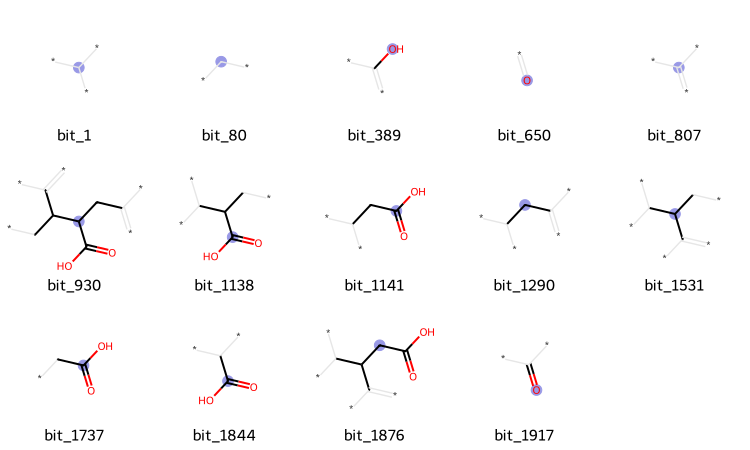

In [ ]:
MorganFingerprint().draw_bits(smi_conv, [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])

Explaining Model

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

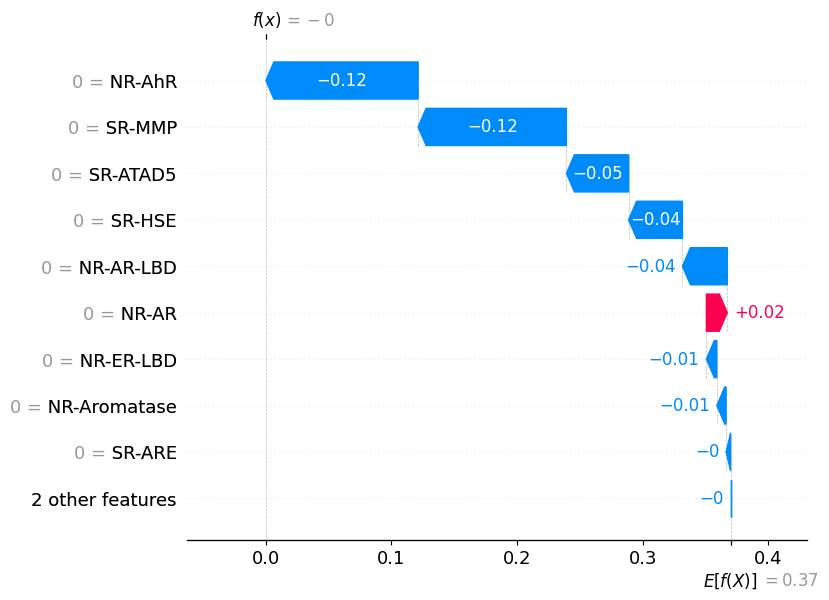

In [ ]:
# compute shap values
shap_calc = ShapValues()
shap_calc.fit(train_dataset, model)
shap_calc.sample_explanation_plot(index=1, plot_type='waterfall')

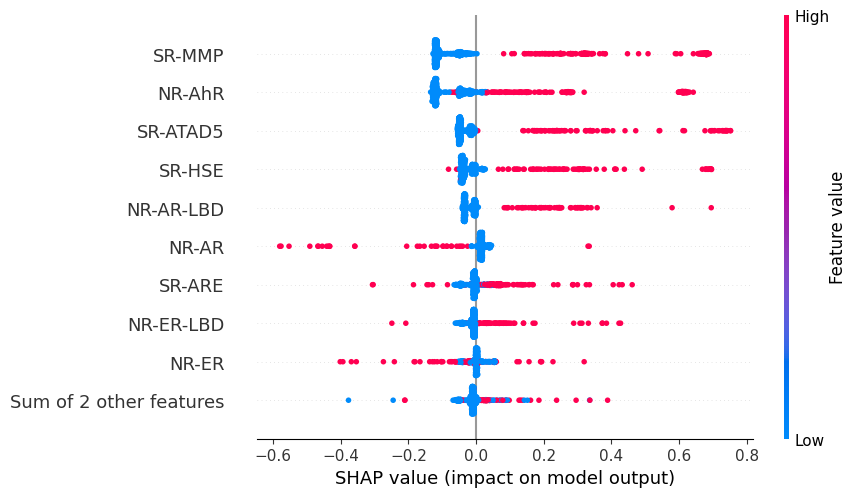

In [ ]:
shap_calc.beeswarm_plot()

In [ ]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 66
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

Prediction:  0
Actual Value:  0.0


In [ ]:
from deepmol.compound_featurization import MorganFingerprint
from rdkit.Chem import rdMolDescriptors
morgan_fp = MorganFingerprint()
bit_info = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    smi_conv, 
    morgan_fp.radius, 
    nBits=morgan_fp.size, 
    useChirality=morgan_fp.chiral, 
    useBondTypes=morgan_fp.bonds, 
    useFeatures=morgan_fp.features, 
    bitInfo=bit_info
)

In [ ]:
active_bits = list(bit_info.keys())

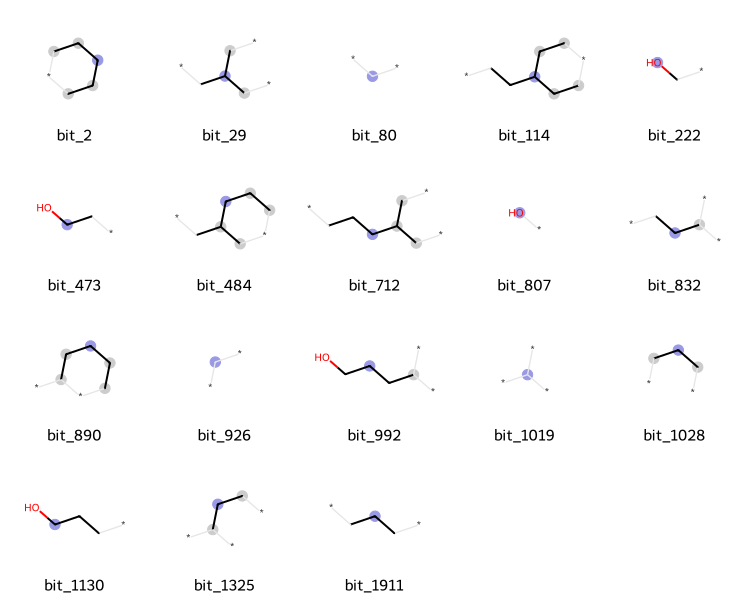

In [ ]:
MorganFingerprint().draw_bits(smi_conv,active_bits)

Prediction:  0.0
Actual Value:  0.0


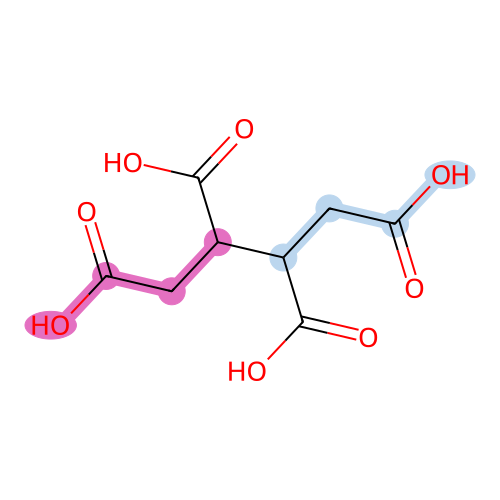

In [ ]:
patt_number = 104 
mol_number = 2

prediction = model.predict(test_dataset)[mol_number]
actual_value = test_dataset.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_dataset.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

2024-05-17 23:27:10,670 — INFO — Bit 1 with 2 hits!


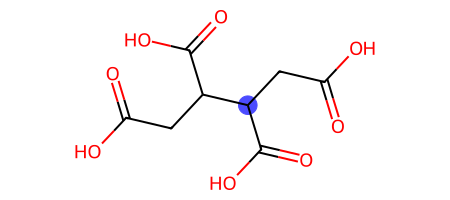

In [ ]:
patt_number = 1
MorganFingerprint().draw_bit(smi, patt_number)

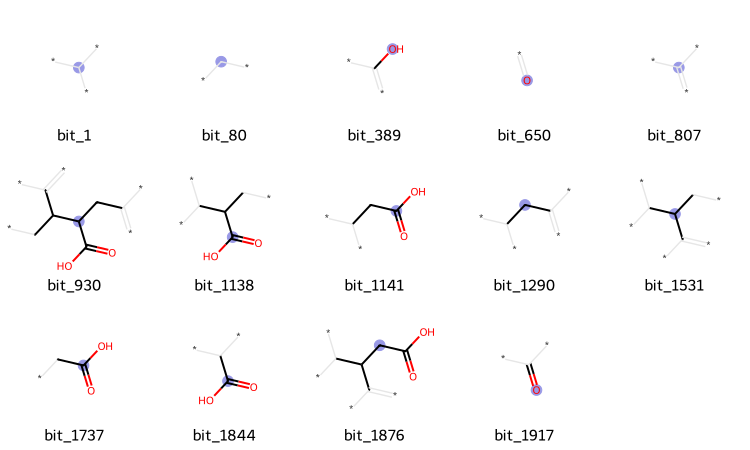

In [ ]:
MorganFingerprint().draw_bits(smi,  [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])

In [ ]:
from rdkit.Chem import rdMolDescriptors
morgan_fp = MorganFingerprint()
bit_info = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    smi, 
    morgan_fp.radius, 
    nBits=morgan_fp.size, 
    useChirality=morgan_fp.chiral, 
    useBondTypes=morgan_fp.bonds, 
    useFeatures=morgan_fp.features, 
    bitInfo=bit_info
)

In [ ]:
active_bits = list(bit_info.keys())

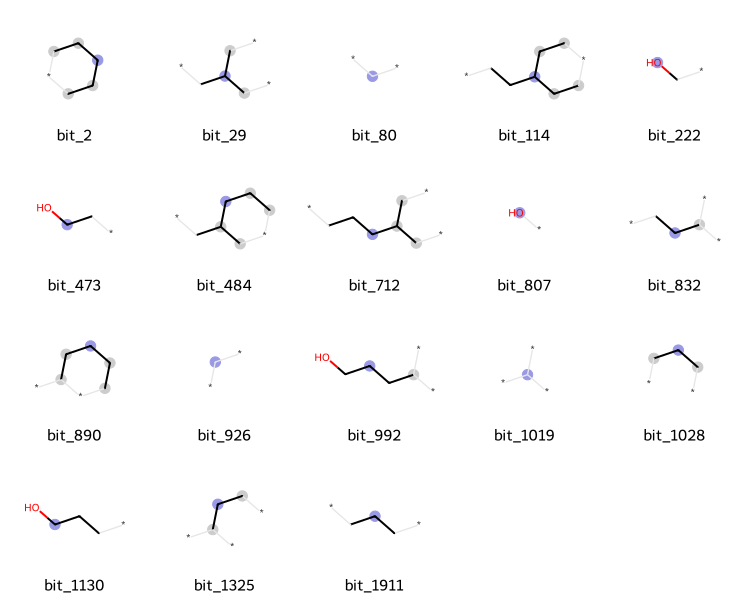

In [ ]:
MorganFingerprint().draw_bits(smi,active_bits)